## Explore the relationship between metacritic score and the current features to find what features to encode or engineer

In [1]:
%config InlineBackend.figure_formats = ['retina']

import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import category_encoders as ce

In [2]:
oscars_df = pd.read_csv('oscar_movies_data.csv')

In [3]:
oscars_df.describe()

,Unnamed: 0,runtime (mins),metacritic score,budget,Total_Noms
count,3303.000000,3303.000000,3303.000000,3.223000e+03,3303.000000
mean,1788.924311,127.243112,76.183470,4.504520e+07,5.398728
std,1049.322783,23.834388,12.732737,4.926863e+07,3.500535
min,0.000000,70.000000,16.000000,6.500000e+04,1.000000
25%,886.500000,111.000000,68.000000,1.400000e+07,2.000000
50%,1781.000000,124.000000,78.000000,2.700000e+07,5.000000
75%,2649.500000,139.000000,86.000000,5.500000e+07,8.000000
max,3711.000000,224.000000,100.000000,3.210000e+08,16.000000


In [4]:
oscars_df.shape

(3303, 23)

In [5]:
oscars_df['Total_Noms'].value_counts()

1     519
2     379
3     318
5     305
4     296
6     284
7     266
8     264
9     207
10    150
12    108
11     99
13     78
16     16
14     14
Name: Total_Noms, dtype: int64

In [6]:
oscars_df.drop(columns = ['Unnamed: 0'],inplace=True)

<Figure size 2880x2880 with 0 Axes>

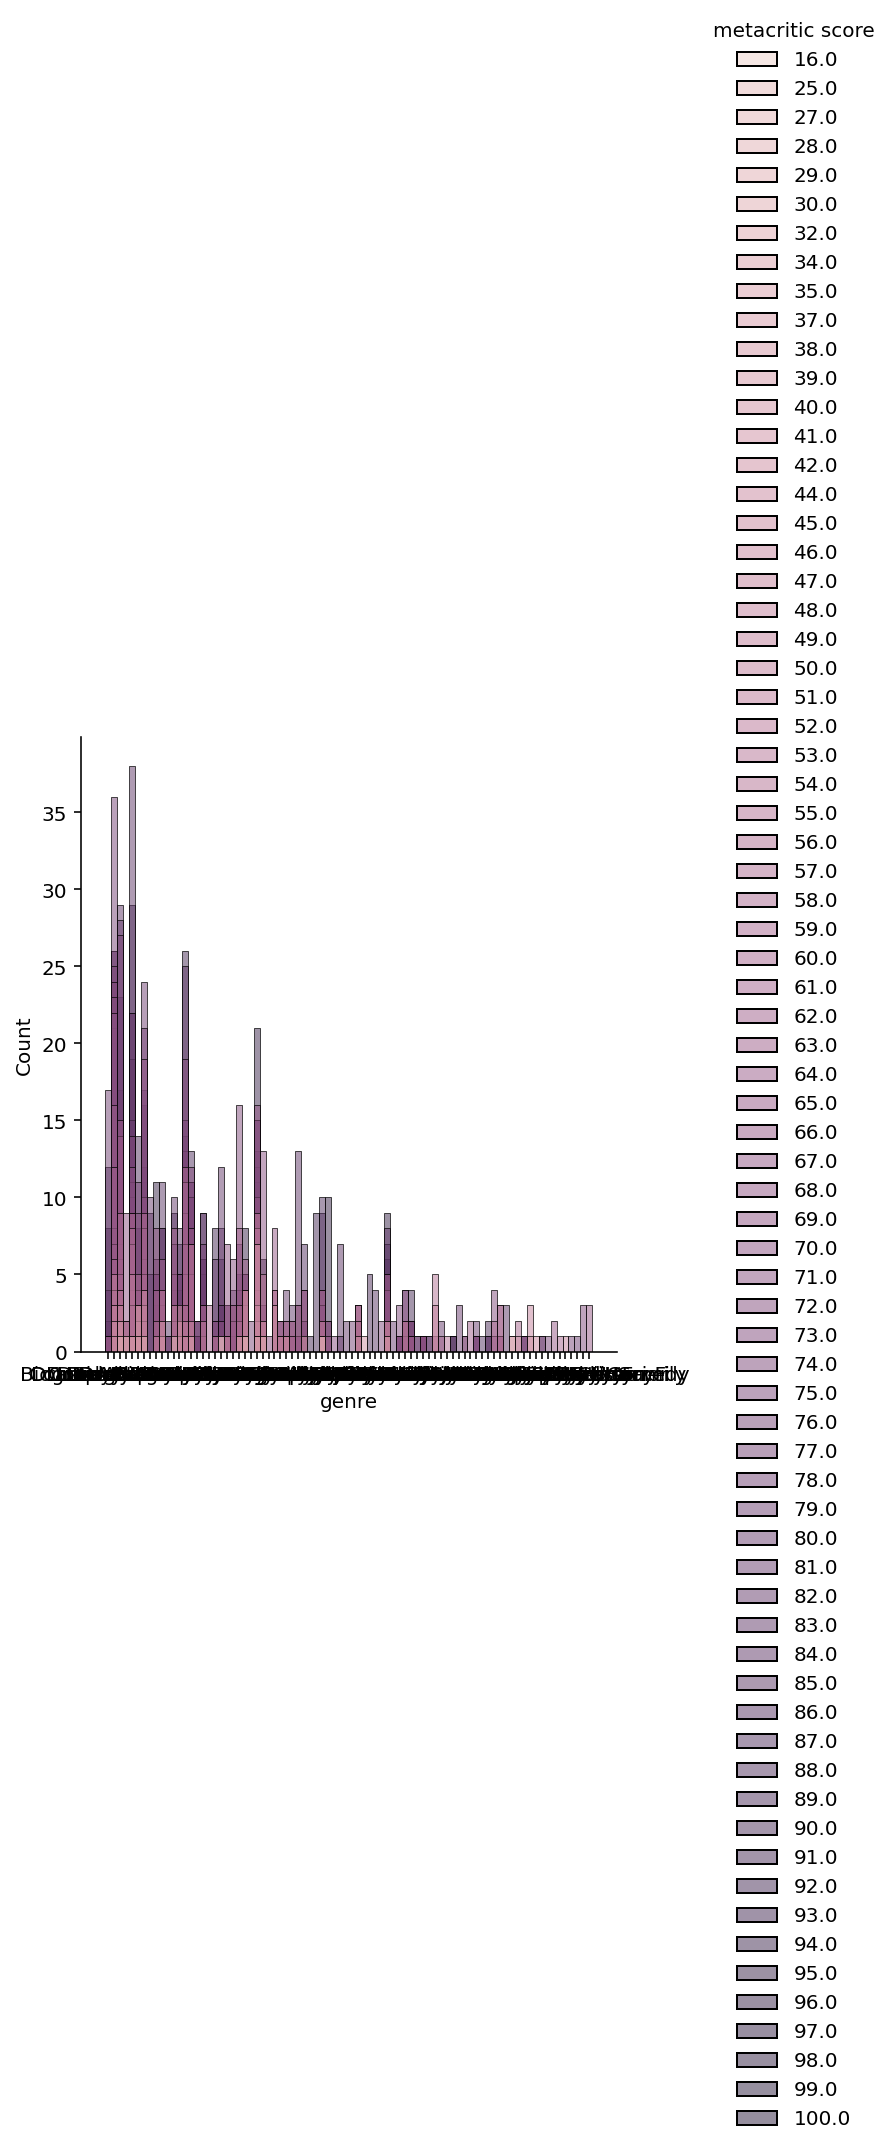

In [7]:
plt.figure(figsize=(40,40))
sns.displot(oscars_df, x="genre", hue="metacritic score");

<Figure size 2880x2880 with 0 Axes>

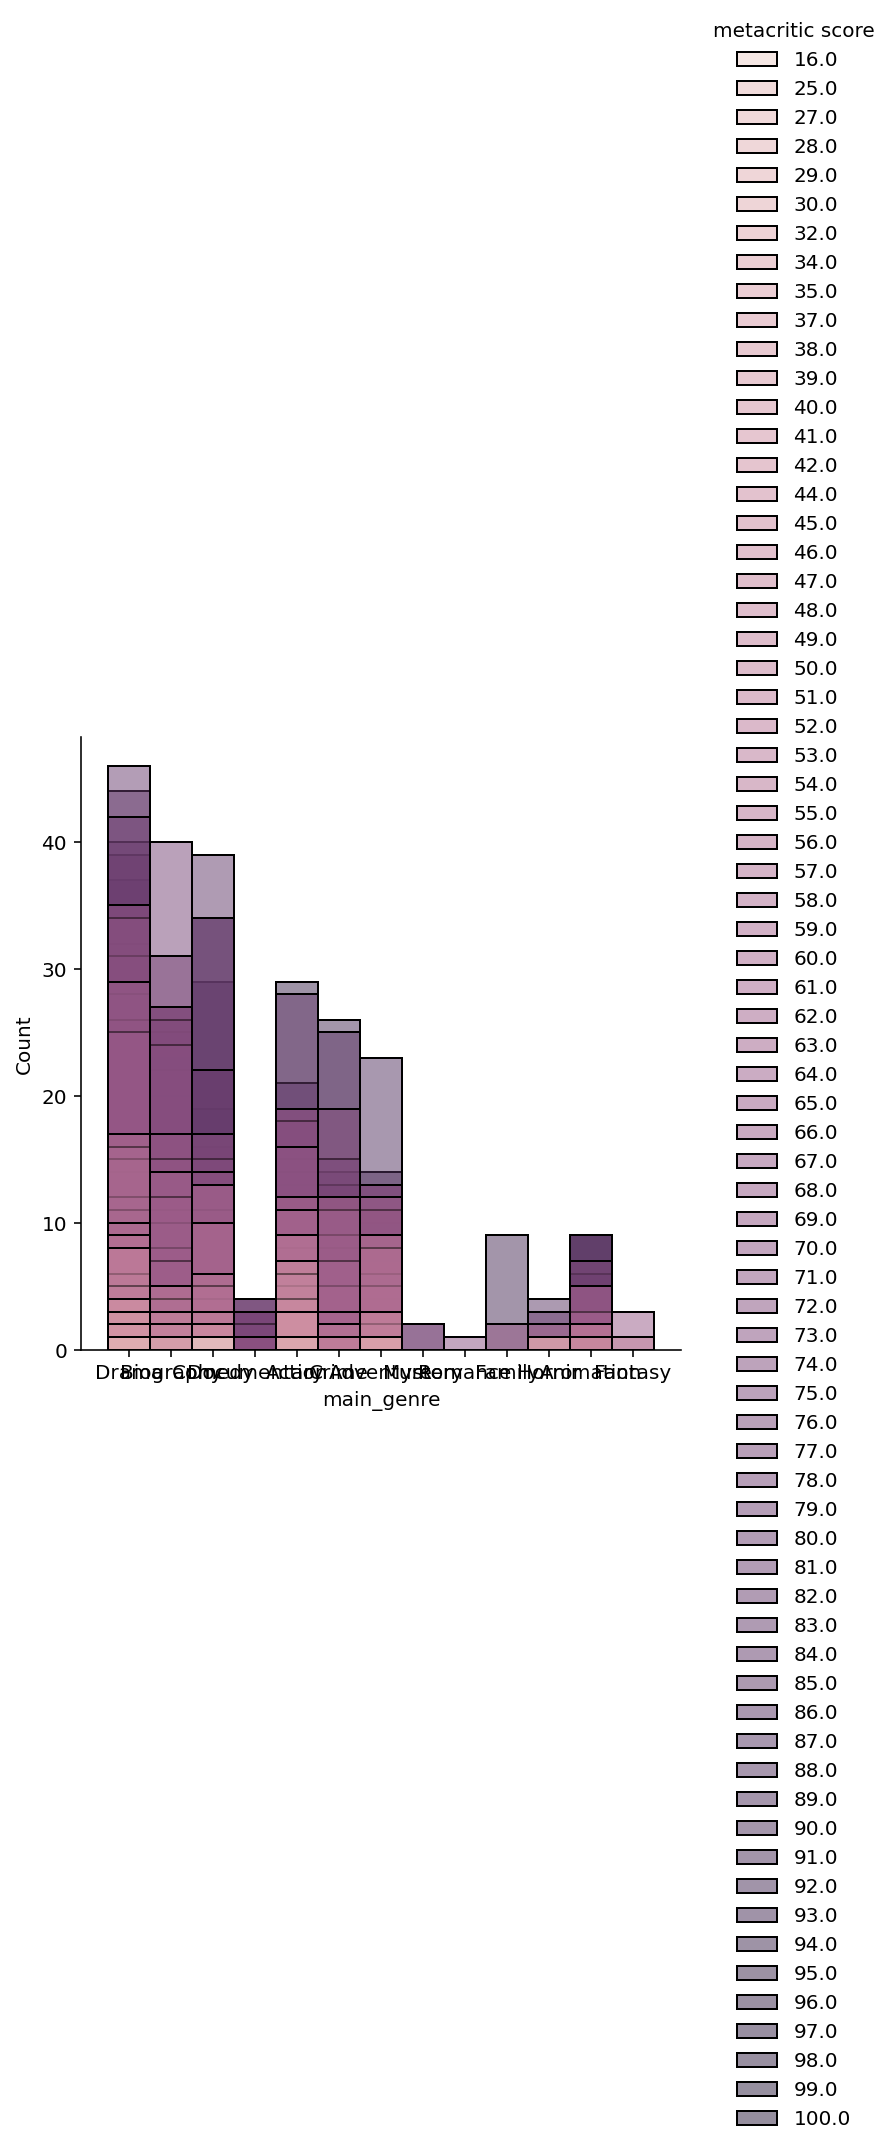

In [8]:
plt.figure(figsize=(40,40))
sns.displot(oscars_df, x="main_genre", hue="metacritic score");

## Create dummies for awards

In [9]:
ce_target = ce.TargetEncoder(cols = ['Awards'])
ce_target.fit(oscars_df, oscars_df['metacritic score'])

ce_target.transform(oscars_df, oscars_df['metacritic score'])

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,writer2,director,Lead_Actor,Supporting_Actor_1,Supporting_Actor_2,genre,main_genre,subgenre,release_date,season
0,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,75.044248,...,NaN,Oliver Stone,Charlie Sheen,Tom Berenger,Willem Dafoe,Drama' 'War,Drama,War,1987-02-06,Winter
1,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,75.895238,...,NaN,Oliver Stone,Charlie Sheen,Tom Berenger,Willem Dafoe,Drama' 'War,Drama,War,1987-02-06,Winter
2,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,81.262295,...,NaN,Oliver Stone,Charlie Sheen,Tom Berenger,Willem Dafoe,Drama' 'War,Drama,War,1987-02-06,Winter
3,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,76.556522,...,NaN,Oliver Stone,Charlie Sheen,Tom Berenger,Willem Dafoe,Drama' 'War,Drama,War,1987-02-06,Winter
4,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,78.639344,...,NaN,Oliver Stone,Charlie Sheen,Tom Berenger,Willem Dafoe,Drama' 'War,Drama,War,1987-02-06,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3298,tt0293508,The Phantom of the Opera,English,UK,143,PG-13,40.0,7.000000e+07,Warner Bros.,70.194444,...,Andrew Lloyd Webber,Joel Schumacher,Gerard Butler,Emmy Rossum,Patrick Wilson,Drama' 'Musical,Drama,Musical,2004-12-10,Winter
3299,tt0097351,Field of Dreams,English,USA,107,PG,57.0,4.425875e+07,Universal Pictures,70.888889,...,Phil Alden Robinson,Phil Alden Robinson,Kevin Costner,James Earl Jones,Ray Liotta,Drama' 'Family,Drama,Family,1989-05-05,Spring
3300,tt0097351,Field of Dreams,English,USA,107,PG,57.0,4.425875e+07,Universal Pictures,78.639344,...,Phil Alden Robinson,Phil Alden Robinson,Kevin Costner,James Earl Jones,Ray Liotta,Drama' 'Family,Drama,Family,1989-05-05,Spring
3301,tt0097351,Field of Dreams,English,USA,107,PG,57.0,4.425875e+07,Universal Pictures,75.333333,...,Phil Alden Robinson,Phil Alden Robinson,Kevin Costner,James Earl Jones,Ray Liotta,Drama' 'Family,Drama,Family,1989-05-05,Spring


In [10]:
top_ten = oscars_df['Awards'].value_counts().iloc[:10]
mask = oscars_df['Awards'].isin(top_ten.index)

In [11]:
oscars_df['Awards'][mask].value_counts()

Best Director                        122
Best Picture                         122
Best Motion Picture of the Year      121
Best Film Editing                    115
Best Actor in a Supporting Role      113
Best Actor in a Leading Role         113
Best Art Direction-Set Decoration    107
Best Cinematography                  105
Best Actress in a Leading Role       102
Best Sound                           102
Name: Awards, dtype: int64

In [12]:
top_awards= oscars_df['Awards'][mask]

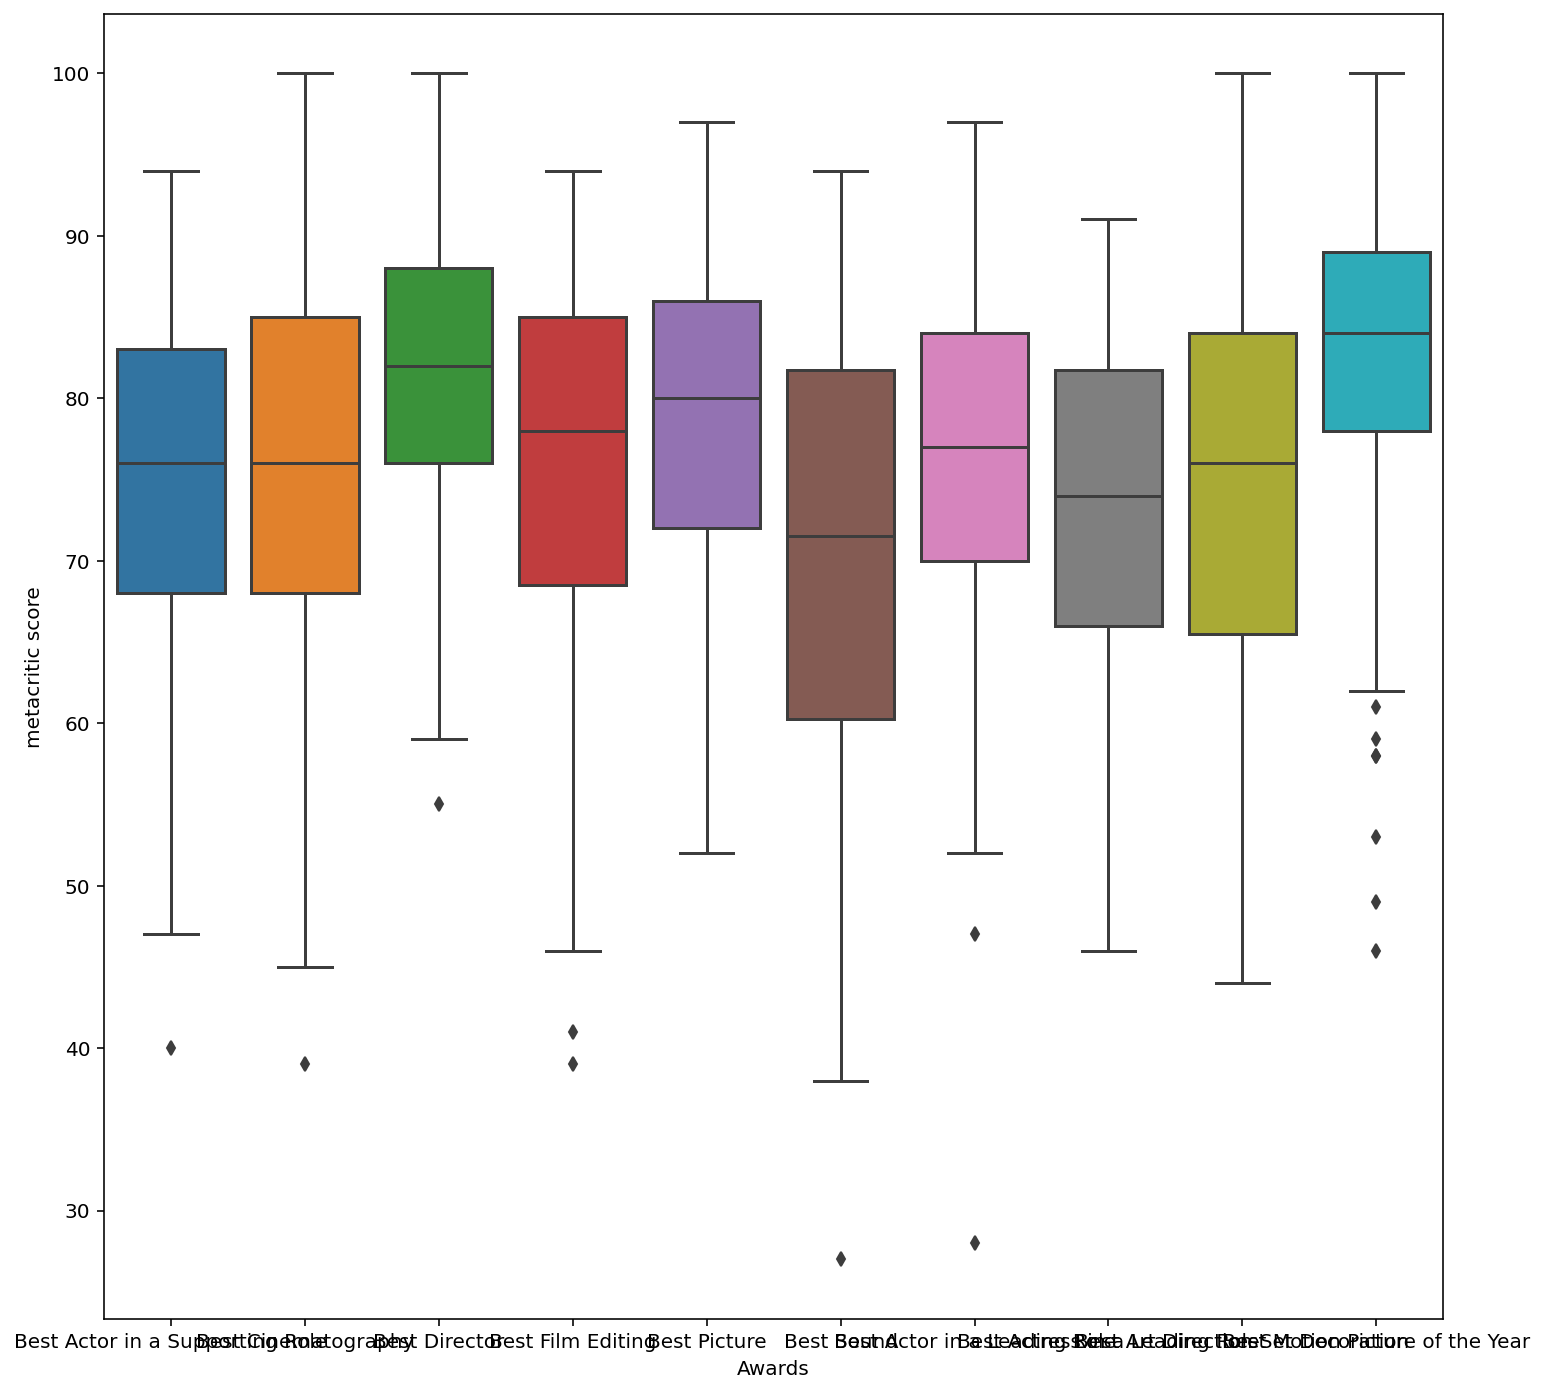

In [13]:
plt.figure(figsize=(12,12))
sns.boxplot(x=top_awards, y="metacritic score", data=oscars_df);

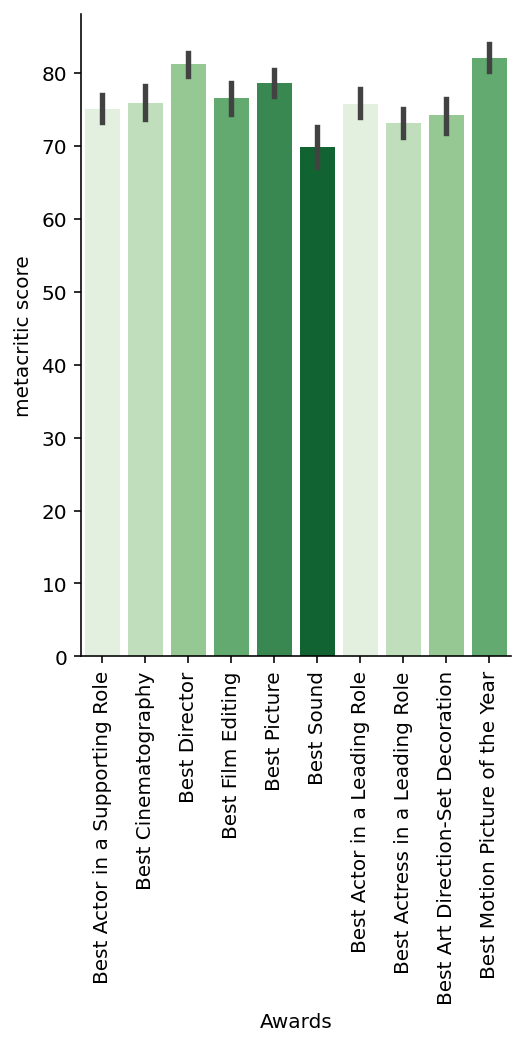

In [16]:
ax = sns.catplot(data=oscars_df, kind="bar", x=top_awards, y="metacritic score",palette = sns.color_palette('Greens'))
plt.xticks(rotation=90);
ax.savefig("output.png")

In [14]:
oscars_df.groupby(['Awards'])['metacritic score'].mean()

Awards
Best Achievement in Art Direction                                              72.294118
Best Achievement in Cinematography                                             80.615385
Best Achievement in Costume Design                                             71.805556
Best Achievement in Directing                                                  84.590361
Best Achievement in Film Editing                                               81.902439
Best Achievement in Makeup                                                     65.428571
Best Achievement in Makeup and Hairstyling                                     68.809524
Best Achievement in Music Written for Motion Pictures (Original Score)         80.777778
Best Achievement in Music Written for Motion Pictures (Original Song)          75.857143
Best Achievement in Music Written for Motion Pictures, Original Score          78.745455
Best Achievement in Music Written for Motion Pictures, Original Song           70.194444
Best Achieveme

In [15]:
oscars_df['Avg_Award_Score'] =  oscars_df.groupby(['Awards'])['metacritic score'].transform('mean')

In [16]:
oscars_df['Avg_Award_Score'].max()

86.11111111111111

In [17]:
oscars_df.shape

(3303, 23)

In [18]:
awards_dummies = pd.get_dummies(oscars_df['Awards'][mask],prefix='Awards')

In [19]:
oscars_df = pd.concat([oscars_df, awards_dummies], axis=1)

In [20]:
oscars_df.groupby('Awards')['IMDBId'].value_counts()

Awards                                                    IMDBId   
Best Achievement in Art Direction                         tt0293508    1
                                                          tt0308644    1
                                                          tt0338751    1
                                                          tt0339291    1
                                                          tt0343737    1
                                                                      ..
Best Writing, Screenplay Written Directly for the Screen  tt0211915    1
                                                          tt0249462    1
                                                          tt0265666    1
                                                          tt0280707    1
                                                          tt0285742    1
Name: IMDBId, Length: 3291, dtype: int64

In [21]:
oscars_df.drop_duplicates(subset=['IMDBId'],inplace=True)

## Create some numeric columns around metacritic score

In [22]:
oscars_df['Director_Avg_Score'] =  oscars_df.groupby(['director'])['metacritic score'].transform('mean')

In [23]:
oscars_df['Director_Avg_Score']

0       71.666667
7       73.000000
19      74.000000
25      75.500000
26      74.000000
          ...    
3292    80.000000
3293    68.727273
3296    52.750000
3299    57.000000
3302    55.000000
Name: Director_Avg_Score, Length: 1136, dtype: float64

In [24]:
oscars_df.groupby('director')['metacritic score'].mean()

director
"Gavin O'Connor"        73.0
Aaron Blaise            48.0
Aaron Sorkin            71.0
Abderrahmane Sissako    92.0
Adam McKay              71.0
                        ... 
Yôji Yamada             82.0
Yôjirô Takita           68.0
Zana Briski             78.0
Zaza Urushadze          73.0
Ziad Doueiri            72.0
Name: metacritic score, Length: 613, dtype: float64

In [25]:
oscars_df.groupby('director')['movie title'].count()

director
"Gavin O'Connor"        2
Aaron Blaise            1
Aaron Sorkin            1
Abderrahmane Sissako    1
Adam McKay              2
                       ..
Yôji Yamada             1
Yôjirô Takita           1
Zana Briski             1
Zaza Urushadze          1
Ziad Doueiri            1
Name: movie title, Length: 613, dtype: int64

In [26]:
oscars_df['Total_Director_Movies'] =  oscars_df.groupby(['director'])['movie title'].transform('count')

In [27]:
oscars_df['Total_Director_Movies'].value_counts()

1     394
2     204
3     165
4     100
6      84
5      50
11     33
12     24
7      21
20     20
9      18
15     15
8       8
Name: Total_Director_Movies, dtype: int64

In [28]:
oscars_df[oscars_df['Total_Director_Movies'] == 20]

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Awards_Best Actress in a Leading Role,Awards_Best Art Direction-Set Decoration,Awards_Best Cinematography,Awards_Best Director,Awards_Best Film Editing,Awards_Best Motion Picture of the Year,Awards_Best Picture,Awards_Best Sound,Director_Avg_Score,Total_Director_Movies
307,tt0088939,The Color Purple,English,USA,154,PG-13,78.0,15000000.0,Warner Bros.,Best Actress in a Leading Role,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.55,20
370,tt0408306,Munich,English,France,164,R,74.0,70000000.0,Universal Pictures,Best Motion Picture of the Year,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,75.55,20
469,tt0118607,Amistad,English,USA,155,R,63.0,36000000.0,DreamWorks Distribution,Best Actor in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.55,20
580,tt0443272,Lincoln,English,USA,150,PG-13,86.0,65000000.0,Touchstone Pictures,Best Motion Picture of the Year,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,75.55,20
841,tt0082971,Raiders of the Lost Ark,English,USA,115,PG,85.0,18000000.0,Paramount Pictures,Best Art Direction-Set Decoration,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,75.55,20
876,tt0108052,Schindler's List,English,USA,195,R,94.0,22000000.0,Universal Pictures,Best Actor in a Leading Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.55,20
989,tt3682448,Bridge of Spies,English,Germany,142,PG-13,81.0,40000000.0,Walt Disney Studios Motion Pictures,Best Motion Picture of the Year,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,75.55,20
1138,tt6294822,The Post,English,USA,116,PG-13,83.0,50000000.0,Twentieth Century Fox,Best Motion Picture of the Year,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,75.55,20
1207,tt0083866,E.T. the Extra-Terrestrial,English,USA,115,PG,91.0,10500000.0,Universal Pictures,Best Cinematography,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,75.55,20
1280,tt0120815,Saving Private Ryan,English,USA,169,R,91.0,70000000.0,DreamWorks Distribution,Best Actor in a Leading Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.55,20


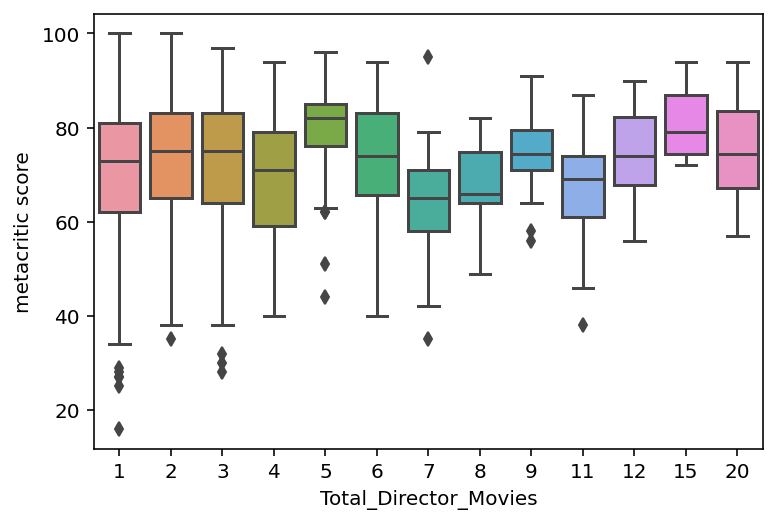

In [29]:
sns.boxplot(x='Total_Director_Movies', y="metacritic score", data=oscars_df);

<AxesSubplot:xlabel='Total_Noms', ylabel='movie title'>

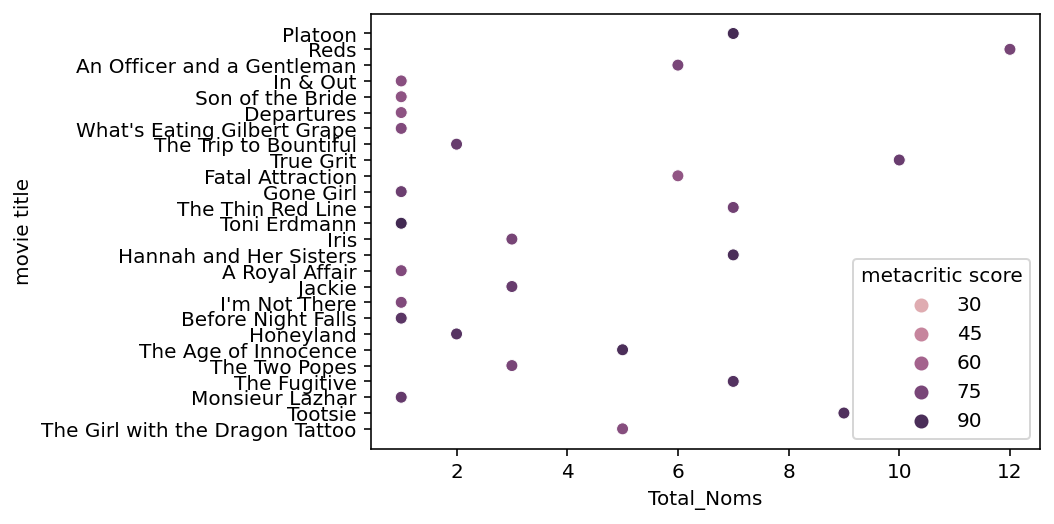

In [30]:
sns.scatterplot(x="Total_Noms", y=oscars_df['movie title'].loc[:100],
                hue="metacritic score",data=oscars_df)

In [54]:
top_ten = oscars_df['director'].value_counts().iloc[:10]
mask = oscars_df['director'].isin(top_ten.index)

In [55]:
top_directors = oscars_df['director'][mask]

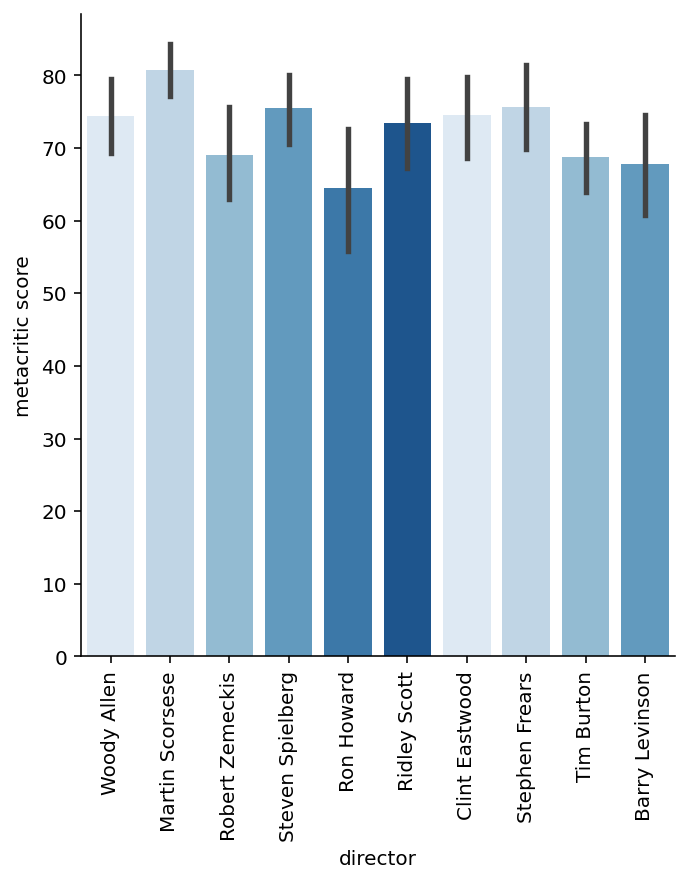

In [82]:
sns.catplot(data=oscars_df, kind="bar", x=top_directors, y="metacritic score",palette = sns.color_palette('Blues'))
plt.xticks(rotation=90);

In [62]:
plt.savefig('director_cat_plot.jpg', dpi=400)

<Figure size 432x288 with 0 Axes>

## Create a lead actor 

In [31]:
oscars_df.groupby('Lead_Actor')['metacritic score'].mean()

Lead_Actor
"Auli'i Cravalho"                    81.0
"Elizabeth 'Eliza' Maganga Nsese"    84.0
"Jack O'Connell"                     59.0
"Latrenda 'Boosie' Ash"              85.0
"O'Shea Jackson Jr."                 72.0
                                     ... 
Yun-Fat Chow                         82.0
Zachary Quinto                       76.0
Zaide Silvia Gutiérrez               67.0
Zain Al Rafeea                       75.0
Ziyi Zhang                           89.0
Name: metacritic score, Length: 645, dtype: float64

In [32]:
oscars_df['Lead_Actor_Avg_Score'] =  oscars_df.groupby(['Lead_Actor'])['metacritic score'].transform('mean')

In [33]:
oscars_df.sort_values('Lead_Actor')

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Awards_Best Art Direction-Set Decoration,Awards_Best Cinematography,Awards_Best Director,Awards_Best Film Editing,Awards_Best Motion Picture of the Year,Awards_Best Picture,Awards_Best Sound,Director_Avg_Score,Total_Director_Movies,Lead_Actor_Avg_Score
2698,tt3521164,Moana,English,USA,107,PG,81.0,1.500000e+08,Walt Disney Studios Motion Pictures,Best Achievement in Music Written for Motion P...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.000000,6,81.0
3015,tt0424024,Darwin's Nightmare,English,Austria,107,Unrated,84.0,NaN,International Film Circuit,"Best Documentary, Features",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.000000,1,84.0
3182,tt1809398,Unbroken,English,USA,137,PG-13,59.0,6.500000e+07,Universal Pictures,Best Achievement in Cinematography,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.000000,1,59.0
2808,tt6634646,"Hale County This Morning, This Evening",English,USA,76,Not Rated,85.0,NaN,The Cinema Guild,Best Documentary Feature,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.000000,1,85.0
3066,tt1398426,Straight Outta Compton,English,USA,147,R,72.0,2.800000e+07,Universal Pictures,"Best Writing, Original Screenplay",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.000000,1,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,tt0190332,"Crouching Tiger, Hidden Dragon",Mandarin,Taiwan,120,PG-13,94.0,1.700000e+07,Sony Pictures Classics,Best Art Direction-Set Decoration,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,86.000000,4,82.0
3068,tt1615147,Margin Call,English,USA,107,R,76.0,3.500000e+06,Lionsgate,"Best Writing, Original Screenplay",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.000000,1,76.0
2859,tt0085482,El Norte,Spanish,UK,141,R,67.0,3.000000e+06,Cinecom Pictures,"Best Writing, Screenplay Written Directly for ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.000000,1,67.0
2375,tt8267604,Capharnaüm,Arabic,Lebanon,126,R,75.0,4.000000e+06,Sony Pictures Classics,Best Foreign Language Film of the Year,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,1,75.0


In [34]:
oscars_df.shape

(1136, 36)

In [35]:
oscars_df['Total_Movies_Lead_Actor']=oscars_df.groupby(['Lead_Actor'])['movie title'].transform('count')

In [36]:
oscars_df['Total_Movies_Lead_Actor'].value_counts()

1     454
2     164
3     141
4     104
5      50
8      48
7      42
6      36
12     24
19     19
9      18
15     15
11     11
10     10
Name: Total_Movies_Lead_Actor, dtype: int64

In [37]:
oscars_df.groupby(['main_genre'])['metacritic score'].mean()

main_genre
Action         66.960265
Adventure      67.605263
Animation      75.307692
Biography      73.738095
Comedy         72.178010
Crime          73.777778
Documentary    81.024390
Drama          72.557927
Family         78.000000
Fantasy        55.000000
Horror         56.500000
Mystery        77.000000
Romance        70.000000
Name: metacritic score, dtype: float64

In [38]:
oscars_df.main_genre.value_counts()

Drama          328
Comedy         191
Biography      168
Action         151
Crime           90
Animation       78
Adventure       76
Documentary     41
Horror           6
Family           2
Fantasy          2
Mystery          2
Romance          1
Name: main_genre, dtype: int64

In [39]:
oscars_df.subgenre.value_counts()

Drama        408
Adventure    134
Romance       92
Comedy        57
Crime         55
Mystery       34
Music         31
Thriller      27
History       27
Fantasy       26
Biography     25
Family        25
War           18
Sci-Fi        16
Action        12
Horror        10
Sport          8
Musical        6
Western        5
News           2
Animation      1
Name: subgenre, dtype: int64

In [40]:
oscars_df['Avg_Rating_by_Genre'] = oscars_df.groupby(['genre'])['metacritic score'].transform('mean')

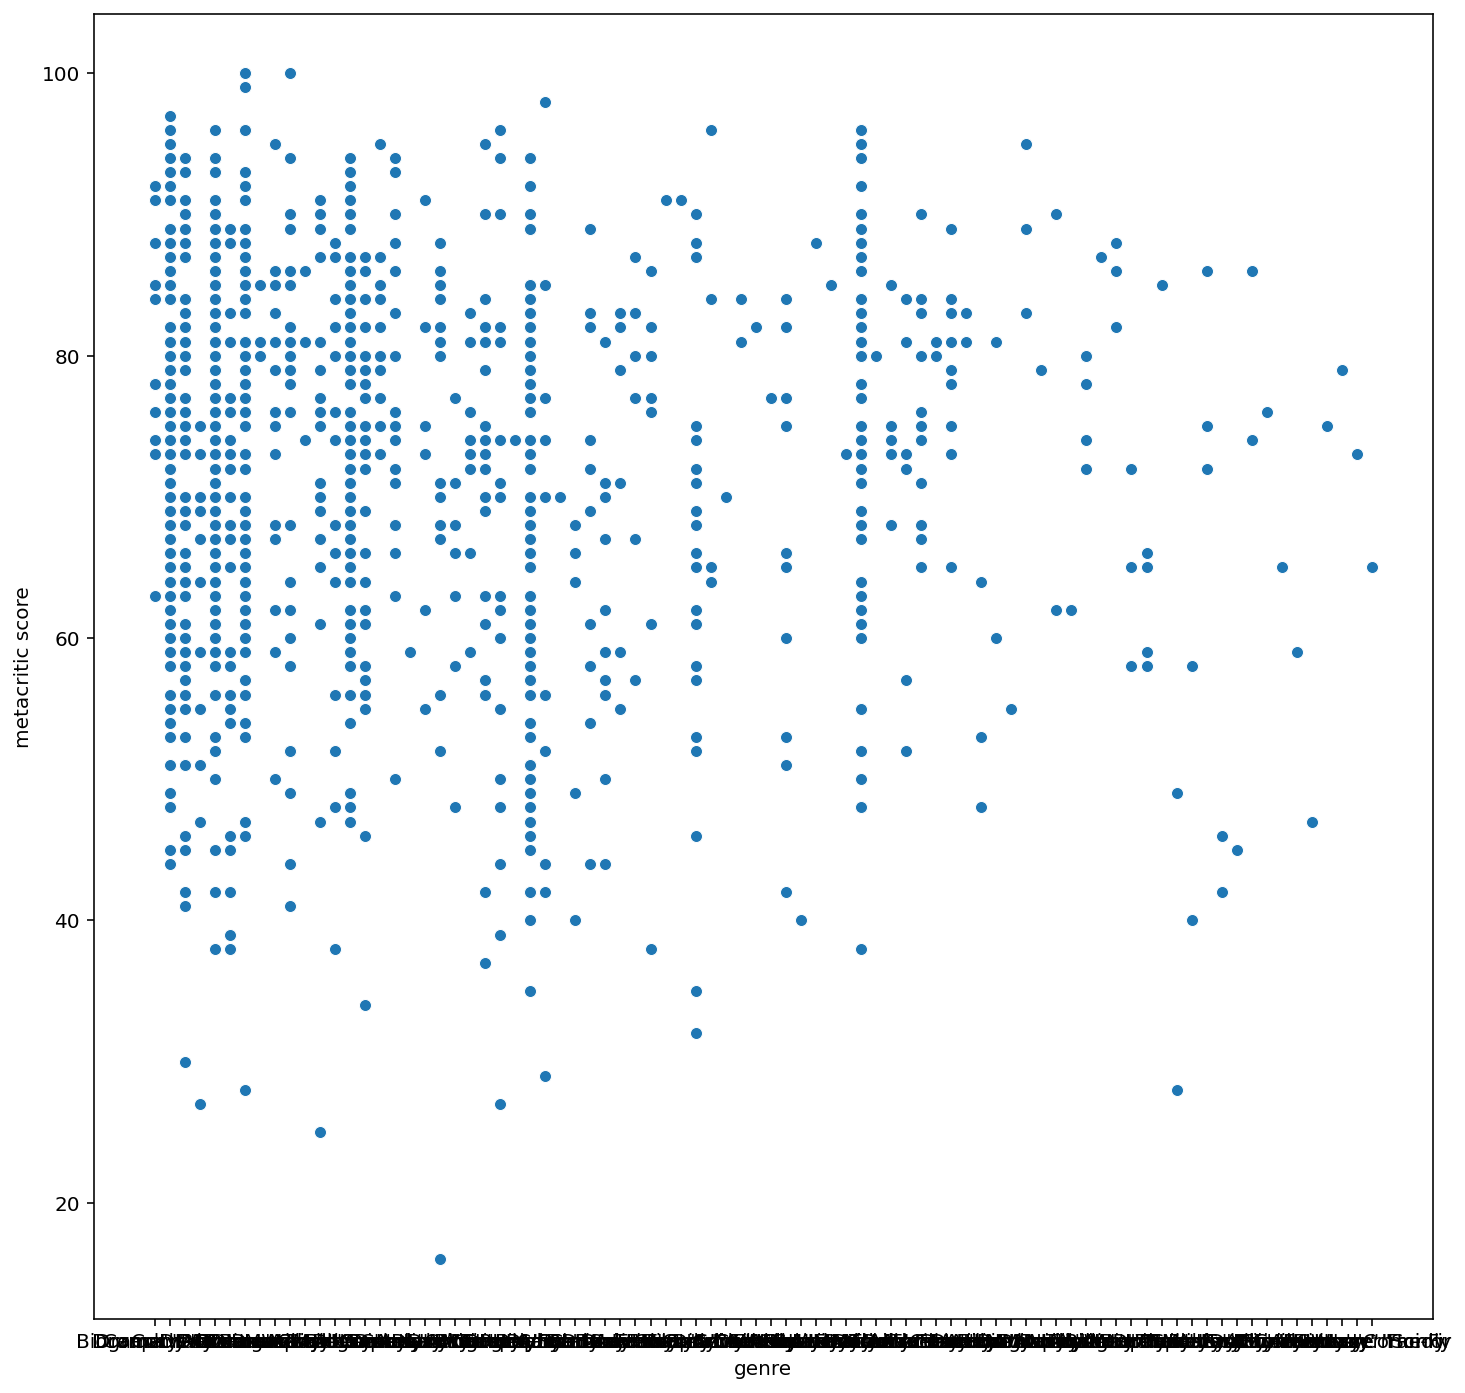

In [49]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=oscars_df['genre'], y="metacritic score", data=oscars_df);

In [18]:
mask = get_top_ten('Lead_Actor')
top_actor = oscars_df['Lead_Actor'][mask].value_counts()

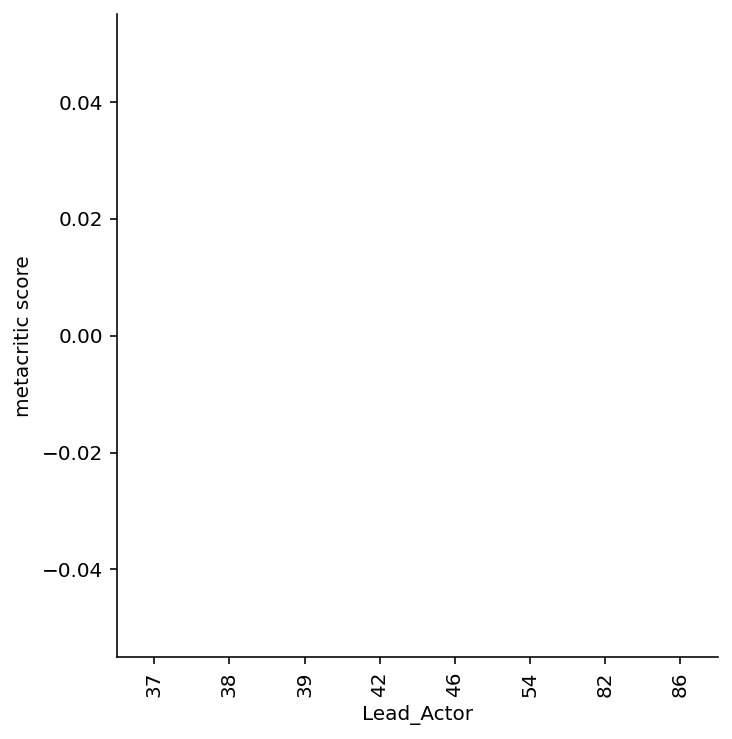

In [19]:
sns.catplot(data=oscars_df, kind="bar", x=top_actor, y="metacritic score",palette = sns.color_palette('Blues'))
plt.xticks(rotation=90);

In [42]:
oscars_df.groupby(['genre'])['metacritic score'].mean()

genre
Action' 'Adventure    66.541176
Action' 'Biography    73.000000
Action' 'Comedy       65.250000
Action' 'Crime        70.647059
Action' 'Drama        64.526316
                        ...    
Horror' 'Sci-Fi       49.000000
Horror' 'Thriller     79.000000
Mystery' 'Sci-Fi      74.000000
Mystery' 'Thriller    80.000000
Romance' 'Sci-Fi      70.000000
Name: metacritic score, Length: 82, dtype: float64

In [43]:
oscars_df

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Awards_Best Director,Awards_Best Film Editing,Awards_Best Motion Picture of the Year,Awards_Best Picture,Awards_Best Sound,Director_Avg_Score,Total_Director_Movies,Lead_Actor_Avg_Score,Total_Movies_Lead_Actor,Avg_Rating_by_Genre
0,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,Best Actor in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,71.666667,6,74.000000,2,81.923077
7,tt0082979,Reds,English,USA,195,PG,76.0,3.200000e+07,Paramount Pictures,Best Actor in a Leading Role,...,0.0,0.0,0.0,0.0,0.0,73.000000,3,74.750000,4,73.604651
19,tt0084434,An Officer and a Gentleman,English,USA,124,R,75.0,7.500000e+06,Paramount Pictures,Best Actor in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,74.000000,2,59.000000,4,71.075000
25,tt0119360,In & Out,English,USA,90,PG-13,70.0,3.500000e+07,Paramount Pictures,Best Actress in a Supporting Role,...,NaN,NaN,NaN,NaN,NaN,75.500000,2,67.000000,2,60.500000
26,tt0292542,Son of the Bride,Spanish,Argentina,123,R,68.0,1.193676e+07,Sony Pictures Classics,Best Foreign Language Film,...,NaN,NaN,NaN,NaN,NaN,74.000000,2,74.000000,2,75.185185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,tt0298203,8 Mile,English,USA,110,R,77.0,4.100000e+07,Universal Pictures,"Best Music, Original Song",...,NaN,NaN,NaN,NaN,NaN,80.000000,3,77.000000,1,66.481481
3293,tt0162661,Sleepy Hollow,English,Germany,105,R,65.0,1.000000e+08,Paramount Pictures,Best Art Direction-Set Decoration,...,0.0,0.0,0.0,0.0,0.0,68.727273,11,68.000000,10,65.000000
3296,tt0293508,The Phantom of the Opera,English,UK,143,PG-13,40.0,7.000000e+07,Warner Bros.,Best Achievement in Cinematography,...,NaN,NaN,NaN,NaN,NaN,52.750000,4,40.000000,1,57.400000
3299,tt0097351,Field of Dreams,English,USA,107,PG,57.0,4.425875e+07,Universal Pictures,"Best Music, Original Score",...,NaN,NaN,NaN,NaN,NaN,57.000000,1,61.666667,6,76.285714


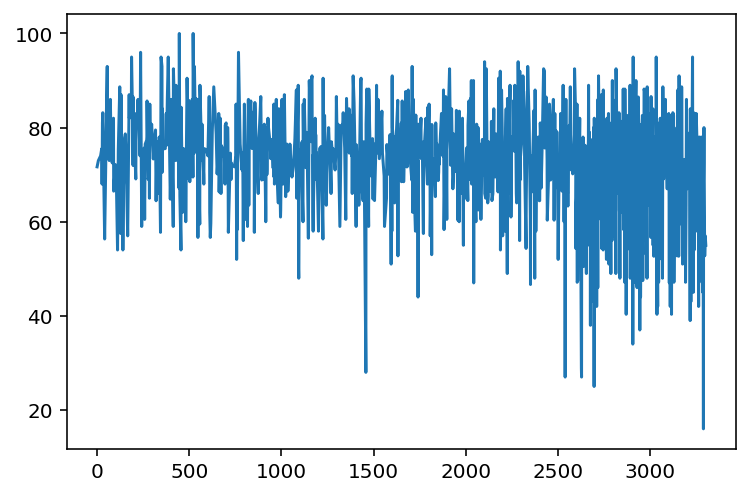

In [44]:
plt.plot(oscars_df['Director_Avg_Score'])

In [45]:
oscars_df.shape

(1136, 38)

In [45]:
oscars_df['Avg_Rating_by_MPAA_Rating'] = oscars_df.groupby(['mpaarating'])['metacritic score'].transform('mean')

In [46]:
oscars_df['Avg_Rating_by_season'] = oscars_df.groupby(['season'])['metacritic score'].transform('mean')

In [47]:
oscars_df['Avg_Rating_by_Distribution_company'] =  oscars_df.groupby(['distributionCompany'])['metacritic score'].transform('mean')

In [48]:
oscars_df['Avg_Rating_by_writer'] =  oscars_df.groupby(['writer1'])['metacritic score'].transform('mean')

## Create some dummy variables

Use this function to get the top 10 columns to create dummy variables with

In [17]:
def get_top_ten(column):
    top_ten = oscars_df[column].value_counts().iloc[:10]
    mask = oscars_df[column].isin(top_ten.index)
    return mask

In [50]:
mask = get_top_ten('distributionCompany')

In [51]:
oscars_df['distributionCompany'][mask].value_counts()

Paramount Pictures                     101
Warner Bros.                            99
Universal Pictures                      86
Twentieth Century Fox                   78
Columbia Pictures                       72
Sony Pictures Classics                  66
Miramax                                 51
Buena Vista Pictures                    44
Walt Disney Studios Motion Pictures     36
Focus Features                          32
Name: distributionCompany, dtype: int64

In [52]:
top_distribution = oscars_df['distributionCompany']

<AxesSubplot:xlabel='distributionCompany', ylabel='metacritic score'>

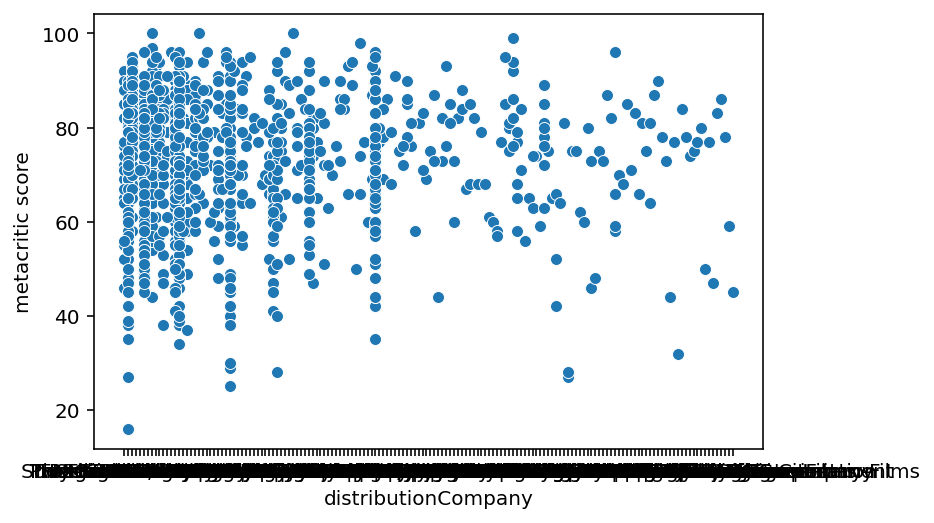

In [53]:
sns.scatterplot(data=oscars_df, x=top_distribution, y="metacritic score")

In [54]:
distro_dummies = pd.get_dummies(oscars_df['distributionCompany'][mask])

In [55]:
oscars_df = pd.concat([oscars_df, distro_dummies], axis=1)

In [56]:
oscars_df.shape

(1136, 52)

## Explore the genre columns

In [57]:
oscars_df['main_genre'].value_counts()

Drama          328
Comedy         191
Biography      168
Action         151
Crime           90
Animation       78
Adventure       76
Documentary     41
Horror           6
Fantasy          2
Family           2
Mystery          2
Romance          1
Name: main_genre, dtype: int64

In [58]:
oscars_df['subgenre'].value_counts()

Drama        408
Adventure    134
Romance       92
Comedy        57
Crime         55
Mystery       34
Music         31
Thriller      27
History       27
Fantasy       26
Biography     25
Family        25
War           18
Sci-Fi        16
Action        12
Horror        10
Sport          8
Musical        6
Western        5
News           2
Animation      1
Name: subgenre, dtype: int64

In [59]:
mask = get_top_ten('main_genre')
oscars_df['main_genre'][mask].value_counts()

Drama          328
Comedy         191
Biography      168
Action         151
Crime           90
Animation       78
Adventure       76
Documentary     41
Horror           6
Fantasy          2
Name: main_genre, dtype: int64

In [60]:
main_genre_dummies = pd.get_dummies(oscars_df['main_genre'][mask],prefix='Genre')

In [61]:
oscars_df = pd.concat([oscars_df, main_genre_dummies], axis=1)

In [62]:
oscars_df.head()

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Fantasy,Genre_Horror
0,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,Best Actor in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,tt0082979,Reds,English,USA,195,PG,76.0,3.200000e+07,Paramount Pictures,Best Actor in a Leading Role,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19,tt0084434,An Officer and a Gentleman,English,USA,124,R,75.0,7.500000e+06,Paramount Pictures,Best Actor in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25,tt0119360,In & Out,English,USA,90,PG-13,70.0,3.500000e+07,Paramount Pictures,Best Actress in a Supporting Role,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
26,tt0292542,Son of the Bride,Spanish,Argentina,123,R,68.0,1.193676e+07,Sony Pictures Classics,Best Foreign Language Film,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [63]:
mask = get_top_ten('subgenre')
oscars_df['subgenre'][mask].value_counts()

Drama        408
Adventure    134
Romance       92
Comedy        57
Crime         55
Mystery       34
Music         31
Thriller      27
History       27
Fantasy       26
Name: subgenre, dtype: int64

In [64]:
subgenre_dummies = pd.get_dummies(oscars_df['subgenre'][mask],prefix='Subgenre')

In [65]:
oscars_df = pd.concat([oscars_df, subgenre_dummies], axis=1)

In [66]:
oscars_df.head()

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Subgenre_Adventure,Subgenre_Comedy,Subgenre_Crime,Subgenre_Drama,Subgenre_Fantasy,Subgenre_History,Subgenre_Music,Subgenre_Mystery,Subgenre_Romance,Subgenre_Thriller
0,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,Best Actor in a Supporting Role,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,tt0082979,Reds,English,USA,195,PG,76.0,3.200000e+07,Paramount Pictures,Best Actor in a Leading Role,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19,tt0084434,An Officer and a Gentleman,English,USA,124,R,75.0,7.500000e+06,Paramount Pictures,Best Actor in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25,tt0119360,In & Out,English,USA,90,PG-13,70.0,3.500000e+07,Paramount Pictures,Best Actress in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26,tt0292542,Son of the Bride,Spanish,Argentina,123,R,68.0,1.193676e+07,Sony Pictures Classics,Best Foreign Language Film,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create dummy for directors

In [67]:
mask = get_top_ten('director')
oscars_df['director'][mask].value_counts()

Steven Spielberg    20
Martin Scorsese     15
Woody Allen         12
Clint Eastwood      12
Robert Zemeckis     11
Ron Howard          11
Tim Burton          11
Stephen Frears       9
Ridley Scott         9
Barry Levinson       8
Name: director, dtype: int64

In [68]:
director_dummies = pd.get_dummies(oscars_df['director'][mask],prefix='Director')

In [69]:
oscars_df = pd.concat([oscars_df, director_dummies], axis=1)

In [70]:
oscars_df.head()

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Director_Barry Levinson,Director_Clint Eastwood,Director_Martin Scorsese,Director_Ridley Scott,Director_Robert Zemeckis,Director_Ron Howard,Director_Stephen Frears,Director_Steven Spielberg,Director_Tim Burton,Director_Woody Allen
0,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,Best Actor in a Supporting Role,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,tt0082979,Reds,English,USA,195,PG,76.0,3.200000e+07,Paramount Pictures,Best Actor in a Leading Role,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,tt0084434,An Officer and a Gentleman,English,USA,124,R,75.0,7.500000e+06,Paramount Pictures,Best Actor in a Supporting Role,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,tt0119360,In & Out,English,USA,90,PG-13,70.0,3.500000e+07,Paramount Pictures,Best Actress in a Supporting Role,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,tt0292542,Son of the Bride,Spanish,Argentina,123,R,68.0,1.193676e+07,Sony Pictures Classics,Best Foreign Language Film,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
oscars_df.columns

Index(['IMDBId', 'movie title', 'language', 'country', 'runtime (mins)',
       'mpaarating', 'metacritic score', 'budget', 'distributionCompany',
       'Awards', 'Total_Noms', 'writer1', 'writer2', 'director', 'Lead_Actor',
       'Supporting_Actor_1', 'Supporting_Actor_2', 'genre', 'main_genre',
       'subgenre', 'release_date', 'season', 'Avg_Award_Score',
       'Awards_Best Actor in a Leading Role',
       'Awards_Best Actor in a Supporting Role',
       'Awards_Best Actress in a Leading Role',
       'Awards_Best Art Direction-Set Decoration',
       'Awards_Best Cinematography', 'Awards_Best Director',
       'Awards_Best Film Editing', 'Awards_Best Motion Picture of the Year',
       'Awards_Best Picture', 'Awards_Best Sound', 'Director_Avg_Score',
       'Total_Director_Movies', 'Lead_Actor_Avg_Score',
       'Total_Movies_Lead_Actor', 'Avg_Rating_by_Genre',
       'Avg_Rating_by_MPAA_Rating', 'Avg_Rating_by_season',
       'Avg_Rating_by_Distribution_company', 'Avg_Rating_b

## Create dummy for lead actors

In [72]:
mask = get_top_ten('Lead_Actor')
oscars_df['Lead_Actor'][mask].value_counts()

Tom Hanks            19
Meryl Streep         15
Tom Cruise           12
Leonardo DiCaprio    12
Brad Pitt            11
Johnny Depp          10
Harrison Ford         9
Robin Williams        9
Robert Downey Jr.     8
Michael Douglas       8
Name: Lead_Actor, dtype: int64

In [73]:
actor_dummies = pd.get_dummies(oscars_df['Lead_Actor'][mask],prefix='Lead_Actor')

In [74]:
oscars_df = pd.concat([oscars_df, actor_dummies], axis=1)

## Create dummies for season

In [75]:
season_dummies = pd.get_dummies(oscars_df['season'])

In [76]:
oscars_df = pd.concat([oscars_df, season_dummies], axis=1)

## Create dummies for rating

In [77]:
top_six = oscars_df['mpaarating'].value_counts().iloc[:6]
mask = oscars_df['mpaarating'].isin(top_six.index)
ratings_dummies = pd.get_dummies(oscars_df['mpaarating'][mask])

In [78]:
oscars_df = pd.concat([oscars_df, ratings_dummies], axis=1)

## Create dummies for writers

In [79]:
mask = get_top_ten('writer1')


In [80]:
writer_dummies = pd.get_dummies(oscars_df['writer1'][mask],prefix='Writer')

In [81]:
oscars_df = pd.concat([oscars_df, writer_dummies], axis=1)

In [82]:
oscars_df.shape

(1136, 112)

In [83]:
oscars_df.columns

Index(['IMDBId', 'movie title', 'language', 'country', 'runtime (mins)',
       'mpaarating', 'metacritic score', 'budget', 'distributionCompany',
       'Awards',
       ...
       'Writer_Aaron Sorkin', 'Writer_Fran Walsh', 'Writer_Henry James',
       'Writer_Joel Coen', 'Writer_John Logan', 'Writer_Lawrence Kasdan',
       'Writer_Paul Thomas Anderson', 'Writer_Pedro Almodóvar',
       'Writer_Quentin Tarantino', 'Writer_Woody Allen'],
      dtype='object', length=112)

In [84]:
oscars_df.to_csv('oscar_movies_data_2.csv',encoding='utf-8-sig')